In [1]:
import structlog
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

from neural_network_scratch.gzip import read_gzip_from_path

LOGGER = structlog.get_logger()

## Data Loading

In [2]:
IMAGES_TRAIN_PATH = "data/train-images-idx3-ubyte.gz"
LABELS_TRAIN_PATH = "data/train-labels-idx1-ubyte.gz"
IMAGES_TEST_PATH = "data/t10k-images-idx3-ubyte.gz"
LABELS_TEST_PATH = "data/t10k-labels-idx1-ubyte.gz"

In [3]:
train_images_raw = read_gzip_from_path(IMAGES_TRAIN_PATH)
train_labels = read_gzip_from_path(LABELS_TRAIN_PATH)
test_images_raw = read_gzip_from_path(IMAGES_TEST_PATH)
test_labels = read_gzip_from_path(LABELS_TEST_PATH)

In [4]:
LOGGER.info(f"train images: {len(train_images_raw)}")
LOGGER.info(f"train labels: {len(train_labels)}")
LOGGER.info(f"test images: {len(test_images_raw)}")
LOGGER.info(f"test labels: {len(test_labels)}")

TOTAL_SIZE = train_images_raw[0].size
DIMENSIONS = (len(train_images_raw[0]), len(train_images_raw[0]))

LOGGER.info(f"dimensions of image: {TOTAL_SIZE} {DIMENSIONS}")

LABELS = list(set(train_labels))
LOGGER.info(f"labels: {LABELS}")

2024-02-11 18:50:24 [info     ] train images: 60000           
2024-02-11 18:50:24 [info     ] train labels: 60000           
2024-02-11 18:50:24 [info     ] test images: 10000            
2024-02-11 18:50:24 [info     ] test labels: 10000            
2024-02-11 18:50:24 [info     ] dimensions of image: 784 (28, 28)
2024-02-11 18:50:24 [info     ] labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
MAX = max([max(t.flatten()) for t in train_images_raw])

train_images = train_images_raw / MAX
test_images = test_images_raw / MAX

LOGGER.info("normalised images")

2024-02-11 18:50:25 [info     ] normalised images             


In [6]:
from neural_network_scratch import Sample

train = [Sample(image=train_images[i], label=train_labels[i]) for i in range(len(train_images))]

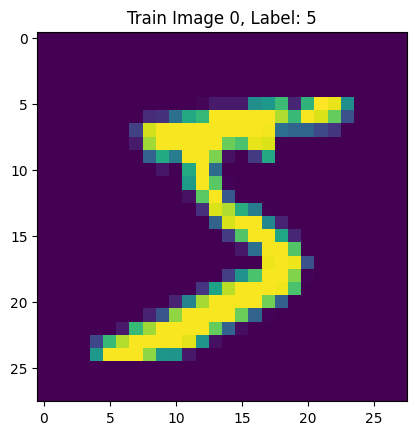

In [7]:
idx = 0
plt.imshow(train_images[idx])
plt.title(f"Train Image {idx}, Label: {train_labels[idx]}")
plt.show()

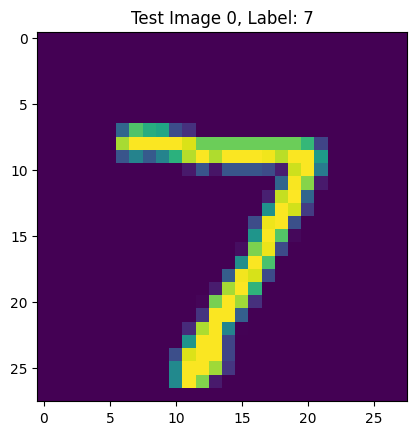

In [8]:
idx = 0
plt.imshow(test_images[idx])
plt.title(f"Test Image {idx}, Label: {test_labels[idx]}")
plt.show()

## Modelling

Given a layer of inputs $\vec{a_{i}}$, a matrix of weights $\vec{W_i}$, biases $\vec{b_i}$ and an activation function $\sigma$, the inputs fed forward to $\vec{a_{i+1}}$ are as follows:
$$\sigma \left( \vec{W_i}\vec{a_{i}} + \vec{b_i} \right)=\vec{a_{i+1}}$$

Cost function, for all weights $\vec{w}$, and for actual outputs $a^{(L)}$ and real outputs $y_i$ (for one such $k$ such that $y_k=1$, and $y_j=0  \forall j \neq k$):
$$C(\vec{w})=\Sigma_{i} (a^{(L)}_i - y_i)^2$$

Need to compute gradient descent step on a batch of the training data at a time (e.g. 10)

$$
\frac{\delta C_0}{\delta w^{(L)}}=\frac{\delta z^{(L)}}{\delta w^{(L)}}\frac{\delta a^{(L)}}{\delta z^{(L)}}\frac{\delta C_0}{\delta a^{(L)}}=2(a^{(L)}-y)\sigma' (z^{(L)})a^{(L-1)}
$$

In [9]:
from neural_network_scratch import Network

network = Network(
    input_size=TOTAL_SIZE,
    hidden_layer_sizes=[16, 16],
    number_classes=len(LABELS),
)

accuracies = network.train(
    train,
    epochs=350,
    batch_size=100,
    learning_rate=0.3,
)

2024-02-11 18:50:29 [debug    ] finished epoch 0 with accuracy of 0.097
2024-02-11 18:52:41 [debug    ] finished epoch 35 with accuracy of 0.31333333333333335
2024-02-11 18:54:35 [debug    ] finished epoch 70 with accuracy of 0.3873333333333333
2024-02-11 18:56:30 [debug    ] finished epoch 105 with accuracy of 0.4745
2024-02-11 18:58:24 [debug    ] finished epoch 140 with accuracy of 0.48966666666666664
2024-02-11 19:00:30 [debug    ] finished epoch 175 with accuracy of 0.6561666666666667
2024-02-11 19:02:31 [debug    ] finished epoch 210 with accuracy of 0.6545
2024-02-11 19:04:31 [debug    ] finished epoch 245 with accuracy of 0.6596666666666666
2024-02-11 19:06:30 [debug    ] finished epoch 280 with accuracy of 0.6618333333333334
2024-02-11 19:08:24 [debug    ] finished epoch 315 with accuracy of 0.6913333333333334


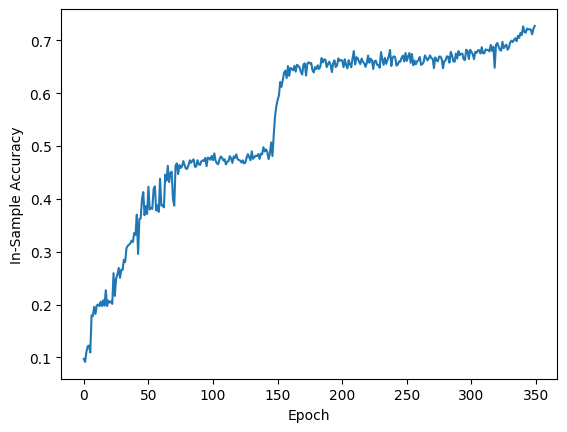

In [10]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("In-Sample Accuracy")
plt.show()

In [11]:
predictions = []

for x in test_images:
    result = network.predict(x.flatten())
    predictions += [result]

LOGGER.info(f"accuracy on test set: {accuracy_score(test_labels, predictions)}")

2024-02-11 19:10:24 [info     ] accuracy on test set: 0.7179  


In [12]:
from sklearn.metrics import classification_report
import numpy as np

print(classification_report(test_labels, predictions, zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.96      0.96      0.96      1135
           2       0.32      0.89      0.47      1032
           3       0.33      0.04      0.07      1010
           4       0.89      0.92      0.90       982
           5       0.77      0.72      0.74       892
           6       0.88      0.89      0.88       958
           7       0.91      0.89      0.90      1028
           8        nan      0.00      0.00       974
           9       0.87      0.88      0.88      1009

    accuracy                           0.72     10000
   macro avg       0.76      0.71      0.67     10000
weighted avg       0.76      0.72      0.68     10000



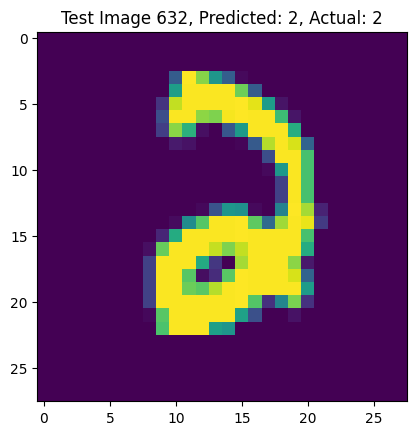

In [14]:
idx = 632
plt.imshow(test_images[idx])
plt.title(f"Test Image {idx}, Predicted: {predictions[idx]}, Actual: {test_labels[idx]}")
plt.show()